# 🛍️ 쇼핑몰 & SNS 리뷰 감성 분석 미션

## 📌 미션 개요
이 미션에서는 **쇼핑몰과 SNS 리뷰 데이터**를 활용하여 감성 분석 모델을 구현한다.  
주어진 리뷰 텍스트(`RawText`)와 라벨(`GeneralPolarity`: -1=부정, 0=중립, 1=긍정)을 기반으로 모델을 학습 및 평가한다.  

특히 두 가지 학습 방식을 비교하는 것이 핵심:
1. **Full Fine-Tuning**: 사전학습 모델 전체를 미세 조정
2. **PEFT (Parameter-Efficient Fine-Tuning)**: 일부 파라미터만 학습하는 경량 학습 기법  

---

## 📂 데이터 설명
- 데이터는 JSON 형식으로 제공되며, 리뷰 하나가 하나의 JSON object로 구성.  
- 주요 필드:
  - `RawText`: 리뷰 원문
  - `GeneralPolarity`: 감성 라벨 (-1=부정, 0=중립, 1=긍정)
  - `Domain`: 리뷰 분야 (패션, 화장품, 가전, IT기기, 생활 등)
  - `Aspects`: 세부 속성별 감성 (옵션)

---

## 🚀 분석 절차
1. **데이터 로드 및 전처리**
   - JSON 파일에서 리뷰 텍스트와 라벨 추출
   - 학습/테스트 데이터 분리

2. **Full Fine-Tuning 모델 학습**
   - Hugging Face `transformers` 활용
   - BERT 기반 분류 모델 fine-tuning


3. **PEFT(LoRA) 모델 학습**
   - Hugging Face `peft` 활용
   - Parameter-efficient fine-tuning 적용

4. **모델 성능 평가 및 비교**
   - 정확도(Accuracy) 평가
   - 학습 속도 비교
   - 모델 파일 용량 비교

---

## 📊 결과 비교 항목
- 학습 속도 (Full Fine-Tuning vs. PEFT)
- 모델 파일 크기
- 감성 분석 정확도 차이



# 0.라이브러리 및 환경 세팅

In [ ]:
!pip install transformers datasets peft accelerate -q

In [2]:
# 라이브러리 임포트
import os, json, random
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from transformers import DataCollatorWithPadding

import torch
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from pathlib import Path

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# google drive 연결

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 한글 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (45.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and direc

In [ ]:
# 나눔 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

# 그래프에 폰트 설정 적용
plt.rcParams['axes.unicode_minus'] = False  # 음수 부호 깨짐 방지
plt.rcParams['font.family'] = 'NanumBarunGothic'

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

# 1.데이터 로드 및 전처리


## 1) 데이터 개요
- 전체 데이터: 201,616개 -> 184,525개
    - `label`:  17,091개 (8.5%)
- 사용할 전체 데이터: 10,464개 -> 9,730개
  - colab ram 용량 부족으로 인해 파일 3개 가져와 샘플링
  - `label`: 768개
-> 결측값 제거


- 칼럼:
    - `text`: 리뷰 텍스트
    - `label`: 감성 라벨 (-1=부정, 0=중립, 1=긍정)
    - `Source`: 데이터 출처(쇼핑몰, SNS)
    - `Domain`: 리뷰 분야(패션, 화장품, 가전, IT기기, 생활)

## 2) 라벨 분포
| Label | Count |
| ----- | ----- |
| -1    | 1,379 |
| 0     | 1,872 |
| 1     | 6,479 |


- 긍정 리뷰가 가장 많고, 중립 및 부정 리뷰는 상대적으로 적음 -> 학습 시. ㅔ이터 불균형 가능성 있음

## 3) Source 분포
| Source | Count |
| ------ | ----- |
| SNS    | 5,768 |
| 쇼핑몰    | 3,962 |


- 쇼핑몰 데이터가 SNS보다 훨씬 많음

## 4) Domain
| Domain | Count |
| ------ | ----- |
| 패션     | 2,395 |
| 화장품    | 2,310 |
| 가전     | 2,013 |
| IT기기   | 1,973 |
| 생활     | 1,039 |


- `생활` 분야 데이터가 상대적으로 매우 적음

## 5) Source x Domain 분포

| Source | Domain | Count |
| ------ | ------ | ----- |
| SNS    | 가전     | 1,361 |
| SNS    | 패션     | 1,210 |
| 쇼핑몰    | 패션     | 1,185 |
| 쇼핑몰    | 화장품    | 1,174 |
| SNS    | 화장품    | 1,136 |
| SNS    | 생활     | 1,039 |
| SNS    | IT기기   | 1,022 |
| 쇼핑몰    | IT기기   | 951   |
| 쇼핑몰    | 가전     | 652   |


- 쇼핑몰 데이터는 화장품/패션 중심. 가전은 상대적으로 적음.
- SNS 데이터는 가전/패션/화장품/생활이 균형있게 분포

## 6) Source x Domain x Label 분포
| Source | Domain | -1  | 0   | 1   |
| ------ | ------ | --- | --- | --- |
| SNS    | 패션     | 59  | 162 | 989 |
| SNS    | 생활     | 25  | 85  | 929 |
| SNS    | 화장품    | 149 | 74  | 913 |
| SNS    | 가전     | 297 | 323 | 741 |
| SNS    | IT기기   | 185 | 395 | 442 |
| 쇼핑몰    | 화장품    | 280 | 106 | 788 |
| 쇼핑몰    | 패션     | 264 | 229 | 692 |
| 쇼핑몰    | IT기기   | 73  | 291 | 587 |
| 쇼핑몰    | 가전     | 47  | 207 | 398 |

- SNS 긍정 리뷰가 전반적으로 우세, 특히 생활/패션은 거의 대부분 긍정
- 쇼핑몰 데이터는 화장품/패션은 긍정이 많지만, IT 기기/가전은 부정과 중립도 상대적으로 존재

----

## 🔹 종합 해석
- **긍정 리뷰가 전체적으로 압도적**이며, Source와 Domain별로 차이가 있음
- SNS는 IT기기와 가전 중심, 쇼핑몰은 화장품과 패션 중심 데이터 분포
- 일부 Source/Domain 조합에서는 중립과 부정 리뷰도 존재하므로, **학습 시 클래스 불균형 처리 필요**


In [ ]:
# 경로 설정
folder_path = '/content/drive/MyDrive/코드잇스프린트/13/review-sentiment-analysis'
sources = ['SNS', '쇼핑몰']
domains = ['01. 패션', '02. 화장품', '03. 가전', '04. IT기기', '05. 생활']


In [ ]:
# @title 1-1. 데이터 로드
all_data = []

sample_size = 3


for source in sources:
    for domain in domains:
        domain_path = os.path.join(folder_path, source, domain)
        if not os.path.exists(domain_path): # 폴더가 없으면 넘어감
            continue
        for root, dirs, files in os.walk(domain_path):
            json_files = [f for f in files if f.endswith('.json')]

            if not json_files:
                continue

            product_groups = {}
            for f in json_files:
                product_id = f.split('.')[0]  # "1-1-1" 같은 prefix
                product_groups.setdefault(product_id, []).append(f)

            for product_id, files in product_groups.items():
                chosen_files = random.sample(files, min(sample_size, len(files)))

                for filename in tqdm(chosen_files, desc=f'{source} - {domain} - {product_id}'):
                    file_path = os.path.join(root, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            data = json.load(f)
                            for review in data:
                                all_data.append({
                                    'Source': review.get('Source'),
                                    'Domain': review.get('Domain'),
                                    'text': review.get('RawText', ''),
                                    'label': review.get('GeneralPolarity')
                                })
                    except FileNotFoundError:
                        print(f"파일 없음: {file_path}")
                    except json.JSONDecodeError:
                        print(f"JSON 오류: {file_path}")

# DataFrame 생성
df = pd.DataFrame(all_data)

# 확인
print()
print(df.shape)
print(df.head())

쇼핑몰 - 04. IT기기 - 4-2: 100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


(10112, 4)
  Source Domain                                               text label
0    SNS     패션  한겨울에는 춥기도 하고 한동안 롱패딩이 유행이라 긴 것만 입고 다녔는데 숏패딩 사고...     1
1    SNS     패션  여러분 제가 드디어 기쁜 소식을 가지고 돌와 왔습니다. 축하 축하^^ 제가 다이어트...     1
2    SNS     패션  이웃님들도 이너로 면티 많이 입으시죠?! 저도 많이 애용하는데 오늘은 제가 늘 재구...     1
3    SNS     패션  맨투맨을 즐겨 입는데 이너로 기본티를 많이 입기 때문에 구매했습니다. 후기 남길게요...     1
4    SNS     패션  가디건을 백화점에서 피팅 해보고 구입하려고 갔다가 사고 싶던 색상이 없어서 다른 색...     1


In [ ]:
# df 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10112 entries, 0 to 10111
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  10112 non-null  object
 1   Domain  10112 non-null  object
 2   text    10112 non-null  object
 3   label   9316 non-null   object
dtypes: object(4)
memory usage: 316.1+ KB


In [ ]:
# 결측값 확인

df.isnull().sum()

,0
Source,0
Domain,0
text,0
label,796


In [ ]:
# @title 1-2. 결측값 제거
df.dropna(subset=['label'], inplace=True)
df.shape

(9316, 4)

In [ ]:
# @title 1-3. type 변경

df['label'] = df['label'].astype(int)

In [ ]:
# @title 1-4. 분포 확인

print("\n라벨별 개수:")
print(df['label'].value_counts().sort_index())

print("\nSource별 개수:")
print(df['Source'].value_counts())

print("\nDomain별 개수:")
print(df['Domain'].value_counts())

print("\nSource별 Domain별 개수:")
print(df[['Source', 'Domain']].value_counts())


print("\nSource별 Domain별 라벨 개수:")
print(df[['Source', 'Domain', 'label']].value_counts())


라벨별 개수:
label
-1    1199
 0    1686
 1    6431
Name: count, dtype: int64

Source별 개수:
Source
SNS    5821
쇼핑몰    3495
Name: count, dtype: int64

Domain별 개수:
Domain
패션      2358
화장품     2089
가전      1904
IT기기    1842
생활      1123
Name: count, dtype: int64

Source별 Domain별 개수:
Source  Domain
SNS     가전        1233
쇼핑몰     패션        1219
SNS     화장품       1194
        패션        1139
        IT기기      1132
        생활        1123
쇼핑몰     화장품        895
        IT기기       710
        가전         671
Name: count, dtype: int64

Source별 Domain별 라벨 개수:
Source  Domain  label
SNS     화장품      1       992
        생활       1       979
        패션       1       972
        가전       1       788
쇼핑몰     패션       1       702
        화장품      1       592
SNS     IT기기     1       550
쇼핑몰     가전       1       432
        IT기기     1       424
SNS     IT기기     0       414
쇼핑몰     패션      -1       284
SNS     가전       0       248
쇼핑몰     패션       0       233
        IT기기     0       228
        화장품     -1      

In [ ]:
# 색상 팔레트
palette_colors = ['#FFA07A', '#90EE90', '#87CEFA']  # 3가지 색상 (라벨별)

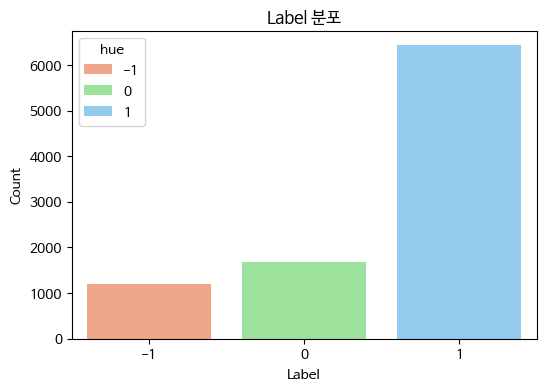

In [ ]:
# =====================
# 1. Label 분포
# =====================
label_counts = df['label'].value_counts().sort_index()
df_label = pd.DataFrame({
    'label': label_counts.index,
    'count': label_counts.values
})
df_label['hue'] = df_label['label']

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_label,
    x='label',
    y='count',
    hue='hue',
    palette=palette_colors,
    dodge=False
)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label 분포')
plt.show()


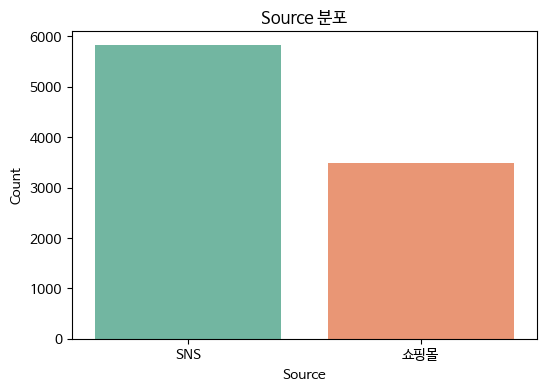

In [ ]:
# =====================
# 2. Source 분포
# =====================
source_counts = df['Source'].value_counts()
df_source = pd.DataFrame({
    'Source': source_counts.index,
    'count': source_counts.values
})
df_source['hue'] = df_source['Source']  # hue에 Source 지정
palette_source = sns.color_palette('Set2', n_colors=len(df_source))

plt.figure(figsize=(6,4))
sns.barplot(
    data=df_source,
    x='Source',
    y='count',
    hue='hue',
    palette=palette_source,
    dodge=False
)
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Source 분포')
plt.show()

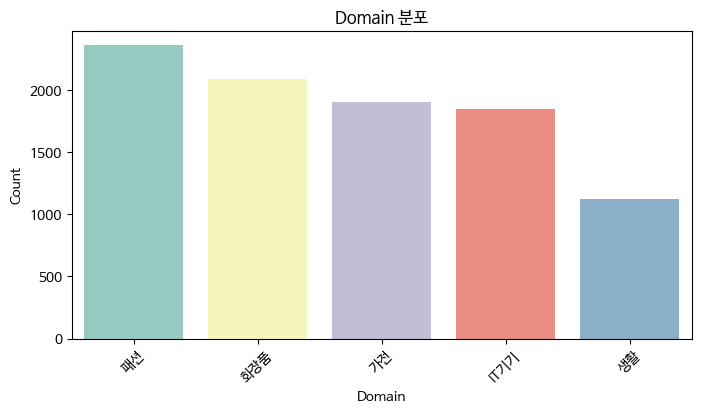

In [ ]:
# =====================
# 3. Domain 분포
# =====================
domain_counts = df['Domain'].value_counts()
df_domain = pd.DataFrame({
    'Domain': domain_counts.index,
    'count': domain_counts.values
})
df_domain['hue'] = df_domain['Domain']
palette_domain = sns.color_palette('Set3', n_colors=len(df_domain))

plt.figure(figsize=(8,4))
sns.barplot(
    data=df_domain,
    x='Domain',
    y='count',
    hue='hue',
    palette=palette_domain,
    dodge=False
)
plt.xticks(rotation=45)
plt.xlabel('Domain')
plt.ylabel('Count')
plt.title('Domain 분포')
plt.show()

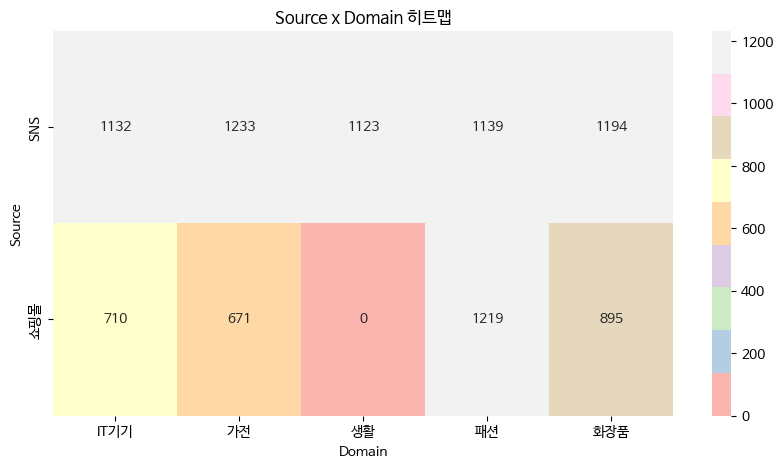

In [ ]:
# =====================
# 4. Source x Domain 분포 (heatmap)
# =====================
source_domain_counts = df.groupby(['Source','Domain']).size().unstack(fill_value=0)

plt.figure(figsize=(10,5))
sns.heatmap(source_domain_counts, annot=True, fmt='d', cmap='Pastel1')
plt.title('Source x Domain 히트맵')
plt.show()


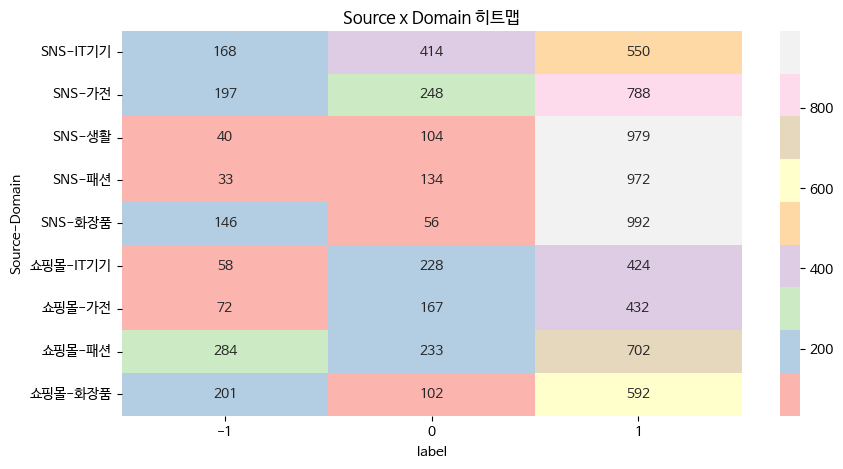

label           -1    0    1
Source Domain               
SNS    IT기기    168  414  550
       가전      197  248  788
       생활       40  104  979
       패션       33  134  972
       화장품     146   56  992
쇼핑몰    IT기기     58  228  424
       가전       72  167  432
       패션      284  233  702
       화장품     201  102  592


In [ ]:
# =====================
# 4. Source x Domain 분포 (heatmap)
# =====================
source_domain_counts = df.groupby(['Source','Domain', 'label']).size().unstack(fill_value=0)


plt.figure(figsize=(10,5))
sns.heatmap(source_domain_counts, annot=True, fmt='d', cmap='Pastel1')
plt.title('Source x Domain 히트맵')
plt.show()

print(source_domain_counts)

In [ ]:
# @title 1-5.텍스트 정제
"""
- HTML, 특수문자, 줄바꿈 제거 등
- \n, \r, 불필요한 공백 제거
- 연속된 글자
"""

def clean_text(text):
    # 줄바꿈 제거 및 공백 정리
    text = text.replace('\n', ' ').strip()
    text = text.replace('\r', ' ').strip()
    text = re.sub(r'\s+', ' ', text)

    # ㅋㅋ, ㅎㅎ, !! 등 반복 문자 2번 이상 -> 1번으로
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 불필요한 특수문자 제거
    text = re.sub(r'[^가-힣a-zA-Z0-9\s\.\,\!\?\~]', '', text)

    return text

df['text'] = df['text'].apply(clean_text)


In [ ]:
# @title 1-6. train/test split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [ ]:
# dataset 저장

# 경로 설정
save_dir = "/content/drive/MyDrive/코드잇스프린트/13/data"
os.makedirs(save_dir, exist_ok=True)  # 없으면 새로 생성

In [ ]:
train_df_path = os.path.join(save_dir, "train_df.parquet")
test_df_path  = os.path.join(save_dir, "test_df.parquet")

In [ ]:
# Parquet 파일로 저장
print("💾 Saving DataFrames to Parquet files...")
train_df.to_parquet(train_df_path, index=False)
test_df.to_parquet(test_df_path, index=False)
print("✅ DataFrames saved successfully!")

💾 Saving DataFrames to Parquet files...
✅ DataFrames saved successfully!


In [ ]:
# Parquet 파일 불러오기
print("🔄 Loading DataFrames from Parquet files...")
train_df = pd.read_parquet(train_df_path)
test_df = pd.read_parquet(test_df_path)
print("✅ DataFrames loaded successfully!")

# 불러온 데이터 확인
display(train_df.head())

🔄 Loading DataFrames from Parquet files...
✅ DataFrames loaded successfully!


,Source,Domain,text,label
0,쇼핑몰,패션,코인이 이뻐서 구매했어요. 줄이 너무 얇아서 놀랐어요. 줄만 금이고 코인은 금이 아...,0
1,SNS,IT기기,실제 구입해사용해보니 프린트된 칼라색상이 레이져프린터에서 보다 좀떨어지지만 그래도 ...,1
2,SNS,생활,참 변함없이 한가지 제품을 사용하기란 쉽지 않은데 오늘은 제가 오랫동안 쓰고 있는 ...,1
3,SNS,가전,사실 저는 디자인에 반해서 이 제품을 구매했다고 해도 과언이 아니에요. 컴팩트하게 ...,-1
4,쇼핑몰,가전,시원하게 걸레질 잘해서 맘이 좋습니다. 먼지통 자동비움 기능 만족 최고 만족입니다....,1


In [ ]:
# @title 1-7. text 길이 확인
def print_stats(name, lengths):
    print(f'[{name}]')
    print(f'  평균 길이: {np.mean(lengths):.1f}')
    print(f'  90% 이하 길이: {np.percentile(lengths, 90):.0f}')
    print(f'  최대 길이: {np.max(lengths)}\n')

In [ ]:
train_text_lengths = train_df['text'].str.len().tolist()
test_text_lengths = test_df['text'].str.len().tolist()

print_stats('Train Text', train_text_lengths)
print_stats('Test Text', test_text_lengths)


[Train Text]
  평균 길이: 234.5
  90% 이하 길이: 392
  최대 길이: 997

[Test Text]
  평균 길이: 231.3
  90% 이하 길이: 385
  최대 길이: 960



In [ ]:
MAX_TOKEN_LENGTH = 400

In [ ]:
# @title 1-8. 토크나이저 준비
"""
Hugging Face 모델 토크나이저 필요
텍스트 -> 토큰 -> 모델
"""
MODEL_NAME = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(
    list(train_df['text']),
    truncation=True,
    padding='max_length',
    max_length=MAX_TOKEN_LENGTH
)
test_encodings = tokenizer(
    list(test_df['text']),
    truncation=True,
    padding='max_length',
    max_length=MAX_TOKEN_LENGTH
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
# @title 1-9. dataset 생성

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        """
        현재 label -1, 0, 1 -> 0, 1, 2 변환
        Hugging Face BertForSequenceClassification은 0부터 시작하는 integer 라벨 필요
        """
        self.encodings = encodings
        self.labels = [l + 1 for l in labels]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = ReviewDataset(train_encodings, list(train_df['label']))
test_dataset = ReviewDataset(test_encodings, list(test_df['label']))

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7452
Test dataset size: 1864


In [ ]:
train_dataset_path = os.path.join(save_dir, "train_dataset.pt")
test_dataset_path  = os.path.join(save_dir, "test_dataset.pt")

In [ ]:
# 데이터셋을 디스크에 저장
print("Saving tokenized datasets to disk...")
torch.save(train_dataset, train_dataset_path)
torch.save(test_dataset, test_dataset_path)
print("✅ Datasets saved successfully!")

Saving tokenized datasets to disk...
✅ Datasets saved successfully!


In [ ]:
# 디스크에서 데이터셋 불러오기
print("Loading tokenized datasets from disk...")

train_dataset = torch.load(train_dataset_path, weights_only=False)
test_dataset = torch.load(test_dataset_path, weights_only=False)
print("✅ Datasets loaded successfully!")


Loading tokenized datasets from disk...
✅ Datasets loaded successfully!


# 2.Full Fine-Tuning 모델 학습

In [ ]:
# @title 2-1. 모델 로드

NUM_LABELS = 3 # (감성 분석 라벨 -1, 0, 1. > 0, 1, 2)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title 2-2. 학습인자 설정

training_args1 = TrainingArguments(
    output_dir='/content/drive/MyDrive/코드잇스프린트/13/results/full_finetuning',
    report_to="none",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/코드잇스프린트/13/logs/full_finetuning',
    logging_steps=20,
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=2,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    push_to_hub=False
)

In [ ]:
# @title 2-3. 평가용 metric

def compute_metrics(eval_pred):
  logits = eval_pred.predictions
  labels = eval_pred.label_ids

  preds = logits.argmax(-1)

  precision, recall, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
  acc = accuracy_score(labels, preds)
  f1 = f1_score(labels, preds, average="weighted", zero_division=0)

  return {
      'accuracy': acc,
      'f1': f1,
      'f1_macro': f1_macro,
      'precision': precision,
      'recall': recall
  }

In [ ]:
# @title 2-4. trainer 객체 생성

full_ft_trainer = Trainer(
    model=model,
    args=training_args1,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# @title 2-5. trainer 학습

full_ft_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro,Precision,Recall
1,0.032500,0.847162,0.850322,0.861074,0.861074,0.887924,0.850322
2,0.261900,0.439905,0.878219,0.878044,0.878044,0.878080,0.878219
3,0.135900,0.537987,0.879828,0.881082,0.881082,0.882575,0.879828


TrainOutput(global_step=1398, training_loss=0.14439228752119004, metrics={'train_runtime': 1741.4773, 'train_samples_per_second': 12.837, 'train_steps_per_second': 0.803, 'total_flos': 4595440286505600.0, 'train_loss': 0.14439228752119004, 'epoch': 3.0})

In [ ]:

# 평가
predictions, labels, _ = full_ft_trainer.predict(test_dataset)

# logits -> predicted label
preds = predictions.argmax(-1)

# 확인
for i in range(len(labels)):
    print(f"예측: {preds[i]}, 실제: {labels[i]}")

예측: 2, 실제: 1
예측: 1, 실제: 1
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 1, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 0, 실제: 0
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 1, 실제: 1
예측: 0, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 0, 실제: 0
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 1, 실제: 2
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 1, 실제: 1
예측: 2, 실제: 2
예측: 1, 실제: 2
예측: 0, 실제: 0
예측: 0, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 0, 실제: 0
예측: 1, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 1, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 1, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 0, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 1, 실제: 2
예측: 2, 실제: 2
예측: 1, 실제: 2
예측: 2, 실제: 2
예측: 1, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 0, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2

In [ ]:
results_df = pd.DataFrame({
    "idx": range(len(labels)),
    "pred": preds,
    "label": labels
})

# CSV로 저장
result_path  = os.path.join(save_dir, "full_ft_test_results.csv")
results_df.to_csv(result_path, index=False)
print("✅ Test 결과 저장 완료")

✅ Test 결과 저장 완료


In [ ]:
# 틀린 샘플만 저장하고 싶으면
results_df = results_df[results_df['pred'] != results_df['label']]

results_df

,idx,pred,label
0,0,2,1
6,6,1,2
29,29,1,2
35,35,2,1
42,42,1,2
...,...,...,...
1815,1815,1,2
1828,1828,2,1
1833,1833,1,2
1850,1850,2,1


# 3.PEFT(LoRA) 모델 학습


In [ ]:
# @title 3-1. 모델 불러오기

base_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title 3-2. LoRA 설정

lora_config = LoraConfig(
    r=16,                               # LoRA rank
    lora_alpha=32,                      # scaling
    target_modules=['query', 'value'],  # BERT의 attention 모듈에 적용
    lora_dropout=0.1,
    bias='none',
    task_type='SEQ_CLS',
)

peft_model = get_peft_model(base_model, lora_config)

peft_model.print_trainable_parameters()    # LoRA 적용된 파라미터만 학습됨 확인

trainable params: 592,131 || all params: 111,211,782 || trainable%: 0.5324


In [ ]:
# @title (추가) CrossEntropyLoss에 클래스 가중치 적용

labels = train_dataset.labels

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)


In [ ]:
# @title 3-3. training Arguments

training_args2 = TrainingArguments(
    output_dir='/content/drive/MyDrive/코드잇스프린트/13/results/lora',
    report_to='none',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    num_train_epochs=5,
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/코드잇스프린트/13/logs/lora',
    logging_steps=20,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
)

In [ ]:
# @title (추가) 손실함수

class CustomTrainer(Trainer):
    def __init__(self, loss_fn=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn or nn.CrossEntropyLoss()

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# @title 3-4. Trainer 정의

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

peft_trainer = CustomTrainer(
    model=model,
    args=training_args2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # loss_fn=loss_fn
)

In [ ]:
peft_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Macro,Precision,Recall
1,0.821800,0.830815,0.690451,0.564018,0.564018,0.476722,0.690451
2,0.857800,0.831429,0.690451,0.564018,0.564018,0.476722,0.690451
3,0.858600,0.829252,0.690451,0.564018,0.564018,0.476722,0.690451
4,0.867700,0.829034,0.690451,0.564018,0.564018,0.476722,0.690451
5,0.735800,0.829061,0.690451,0.564018,0.564018,0.476722,0.690451


TrainOutput(global_step=2330, training_loss=0.8453328869373502, metrics={'train_runtime': 2898.7411, 'train_samples_per_second': 12.854, 'train_steps_per_second': 0.804, 'total_flos': 7659067144176000.0, 'train_loss': 0.8453328869373502, 'epoch': 5.0})

In [ ]:

# 평가
predictions, labels, _ = peft_trainer.predict(test_dataset)

# logits -> predicted label
preds = predictions.argmax(-1)

# 확인
for i in range(len(labels)):
    print(f"예측: {preds[i]}, 실제: {labels[i]}")

예측: 2, 실제: 1
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 1
예측: 2, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 0
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 0
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 1
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 1
예측: 2, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 0
예측: 2, 실제: 2
예측: 2, 실제: 2
예측: 2, 실제: 2

In [ ]:
results_df = pd.DataFrame({
    "idx": range(len(labels)),
    "pred": preds,
    "label": labels
})

# CSV로 저장
result_path  = os.path.join(save_dir, "lora_test_results.csv")
results_df.to_csv(result_path, index=False)
print("✅ Test 결과 저장 완료")

✅ Test 결과 저장 완료


In [ ]:

# 틀린 샘플만 저장하고 싶으면
results_df = results_df[results_df['pred'] != results_df['label']]

results_df

,idx,pred,label
0,0,2,1
1,1,2,1
3,3,2,1
5,5,2,1
15,15,2,0
...,...,...,...
1850,1850,2,1
1854,1854,2,1
1857,1857,2,1
1858,1858,2,1


# 4.모델 성능 평가 및 비교


In [ ]:
save_dir = '/content/drive/MyDrive/코드잇스프린트/13/results'

In [ ]:
# @title 4-1.실험 설정 요약

import pandas as pd

exp_setup = pd.DataFrame({
    "방식": ["Full Fine-Tuning", "LoRA PEFT"],
    "base_model": ["klue/bert-base", "klue/bert-base"],
    "max_length": [MAX_TOKEN_LENGTH, MAX_TOKEN_LENGTH],
    "train_samples": [len(train_df), len(train_df)],
    "test_samples": [len(test_df), len(test_df)],
    "batch_train/eval": [
        f"{training_args1.per_device_train_batch_size}/{training_args1.per_device_eval_batch_size}",
        f"{training_args2.per_device_train_batch_size}/{training_args2.per_device_eval_batch_size}"
    ],
    "epochs": [training_args1.num_train_epochs, training_args2.num_train_epochs],
    "lr": [training_args1.learning_rate, training_args2.learning_rate],
    "warmup_steps": [
        getattr(training_args1, "warmup_steps", None),
        getattr(training_args2, "warmup_steps", None)
    ],
    "class_weight": ["yes" if "weights" in "your note (수동 기록)" else "no",
                     "yes" if "weights" in "your note (수동 기록)" else "no"],
    "seed": [
        training_args1.seed if hasattr(training_args1, "seed") else 42,
        training_args2.seed if hasattr(training_args2, "seed") else 42
    ]
})

exp_setup


,방식,base_model,max_length,train_samples,test_samples,batch_train/eval,epochs,lr,warmup_steps,class_weight,seed
0,Full Fine-Tuning,klue/bert-base,400,7452,1864,16/32,3,0.00002,500,no,42
1,LoRA PEFT,klue/bert-base,400,7452,1864,16/32,5,0.00002,500,no,42


In [ ]:
# @title 4-2. 공통유틸(파라미터/모델크기/혼동행렬/메트릭 수집)


def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return dict(total=total, trainable=trainable, ratio=f"{trainable/total:.2%}")

def get_dir_size_mb(path):
    p = Path(path)
    size = sum(f.stat().st_size for f in p.glob("**/*") if f.is_file()) / (1024*1024)
    return round(size, 2)

def evaluate_and_collect(trainer, test_dataset, run_name, id2label=None, save_pred_path=None):
    # 예측
    raw_pred = trainer.predict(test_dataset)
    logits, labels = raw_pred.predictions, raw_pred.label_ids
    preds = np.argmax(logits, axis=-1)

    # 메트릭
    acc = accuracy_score(labels, preds)
    p_w, r_w, f1_w, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    p_m, r_m, f1_m, _ = precision_recall_fscore_support(labels, preds, average="macro", zero_division=0)

    # 분류 리포트(클래스별)
    target_names = [id2label[i] for i in sorted(np.unique(labels))] if id2label else None
    cls_report = classification_report(labels, preds, target_names=target_names, zero_division=0, output_dict=True)
    report_df = pd.DataFrame(cls_report).T

    # 혼동행렬
    cm = confusion_matrix(labels, preds)
    fig = plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names if target_names else sorted(np.unique(labels)))
    disp.plot(values_format='d')
    plt.title(f"Confusion Matrix - {run_name}")
    plt.show()

    # 예측 결과 저장(옵션)
    if save_pred_path:
        import pandas as pd
        out_df = pd.DataFrame({
            "idx": np.arange(len(labels)),
            "label": labels,
            "pred": preds
        })
        out_df.to_csv(save_pred_path, index=False)

    return {
        "run": run_name,
        "accuracy": acc,
        "f1_weighted": f1_w,
        "precision_weighted": p_w,
        "recall_weighted": r_w,
        "f1_macro": f1_m,
        "report_df": report_df,
        "cm": cm,
        "preds": preds,
        "labels": labels,
        "eval_runtime": raw_pred.metrics.get("eval_runtime", None)
    }

In [ ]:
# Full Fine-Tuning 결과
full_ft_data = {
    "Epoch": [1, 2, 3],
    "Training Loss": [0.032500, 0.261900, 0.135900],
    "Validation Loss": [0.847162, 0.439905, 0.537987],
    "Accuracy": [0.850322, 0.878219, 0.879828],
    "F1": [0.861074, 0.878044, 0.881082],
    "F1 Macro": [0.861074, 0.878044, 0.881082],
    "Precision": [0.887924, 0.878080, 0.882575],
    "Recall": [0.850322, 0.878219, 0.879828],
    "Method": ["Full-FT"] * 3
}
df_full = pd.DataFrame(full_ft_data)
full_csv_path = "/content/drive/MyDrive/코드잇스프린트/13/results/full_ft_epoch_metrics.csv"
df_full.to_csv(full_csv_path, index=False)
print(f"✅ Full Fine-Tuning 결과 저장 완료: {full_csv_path}")


# PEFT(LORA) 결과
peft_data = {
    "Epoch": [1, 2, 3, 4, 5],
    "Training Loss": [0.821800, 0.857800, 0.858600, 0.867700, 0.735800],
    "Validation Loss": [0.830815, 0.831429, 0.829252, 0.829034, 0.829061],
    "Accuracy": [0.690451]*5,
    "F1": [0.564018]*5,
    "F1 Macro": [0.564018]*5,
    "Precision": [0.476722]*5,
    "Recall": [0.690451]*5,
    "Method": ["PEFT-LORA"] * 5
}

df_peft = pd.DataFrame(peft_data)
peft_csv_path = "/content/drive/MyDrive/코드잇스프린트/13/results/peft_lora_epoch_metrics.csv"
df_peft.to_csv(peft_csv_path, index=False)
print(f"✅ PEFT(LORA) 결과 저장 완료: {peft_csv_path}")

✅ Full Fine-Tuning 결과 저장 완료: /content/drive/MyDrive/코드잇스프린트/13/results/full_ft_epoch_metrics.csv
✅ PEFT(LORA) 결과 저장 완료: /content/drive/MyDrive/코드잇스프린트/13/results/peft_lora_epoch_metrics.csv


In [ ]:
# @title 4-3. Full Fine-Tuning 결과 수집

# 1) CSV 불러오기
full_epoch_path = os.path.join(save_dir, "full_ft_epoch_metrics.csv")
full_epoch = pd.read_csv(full_epoch_path)

# 1) 파라미터 수 / 모델 디스크 크기
full_param = count_params(full_ft_trainer.model)
full_size_mb = get_dir_size_mb(full_ft_trainer.args.output_dir)

full_summary = {
    "run": "Full-FT",
    "epochs": full_epoch["Epoch"].tolist(),
    "train_loss": full_epoch["Training Loss"].tolist(),
    "val_loss": full_epoch["Validation Loss"].tolist(),
    "accuracy": full_epoch["Accuracy"].tolist(),
    "f1_weighted": full_epoch["F1"].tolist(),
    "f1_macro": full_epoch["F1 Macro"].tolist(),
    "preds_count": len(df_preds),
    "params_total": full_param["total"],          # 모델 파라미터는 직접 계산
    "params_trainable": full_param["trainable"],  # trainable 파라미터
    "trainable_ratio": full_param["ratio"],
    "model_size_mb": full_size_mb
}
pd.DataFrame([full_summary])


,run,epochs,train_loss,val_loss,accuracy,f1_weighted,f1_macro,preds_count,params_total,params_trainable,trainable_ratio,model_size_mb
0,Full-FT,"[1, 2, 3]","[0.0325, 0.2619, 0.1359]","[0.847162, 0.439905, 0.537987]","[0.850322, 0.878219, 0.879828]","[0.861074, 0.878044, 0.881082]","[0.861074, 0.878044, 0.881082]",1864,110619651,110619651,100.00%,0.0


In [ ]:
# @title 4-4. PERT(LoRA) 결과 수집

# 1) CSV 불러오기
peft_epoch_path = os.path.join(save_dir, "peft_lora_epoch_metrics.csv")
peft_epoch = pd.read_csv(peft_epoch_path)

# 2) 파라미터 수 / 모델 디스크 크기
peft_param = count_params(peft_trainer.model)
peft_size_mb = get_dir_size_mb(peft_trainer.args.output_dir)

peft_summary = {
    "run": "PEFT-LoRA",
    "epochs": peft_epoch["Epoch"].tolist(),
    "train_loss": peft_epoch["Training Loss"].tolist(),
    "val_loss": peft_epoch["Validation Loss"].tolist(),
    "accuracy": peft_epoch["Accuracy"].tolist(),
    "f1_weighted": peft_epoch["F1"].tolist(),
    "f1_macro": peft_epoch["F1 Macro"].tolist(),
    "preds_count": len(peft_preds),
    "params_total": peft_param["total"],          # 모델 파라미터는 직접 계산
    "params_trainable": peft_param["trainable"],  # trainable 파라미터
    "trainable_ratio": peft_param["ratio"],
    "model_size_mb": peft_size_mb
}
pd.DataFrame([peft_summary])


,run,epochs,train_loss,val_loss,accuracy,f1_weighted,f1_macro,preds_count,params_total,params_trainable,trainable_ratio,model_size_mb
0,PEFT-LoRA,"[1, 2, 3, 4, 5]","[0.8218, 0.8578, 0.8586, 0.8677, 0.7358]","[0.830815, 0.831429, 0.829252, 0.829034, 0.829...","[0.690451, 0.690451, 0.690451, 0.690451, 0.690...","[0.564018, 0.564018, 0.564018, 0.564018, 0.564...","[0.564018, 0.564018, 0.564018, 0.564018, 0.564...",1864,110619651,110619651,100.00%,2534.23


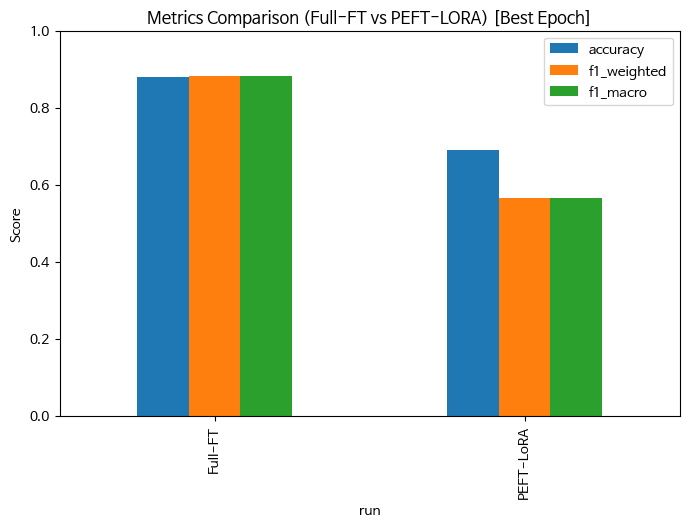

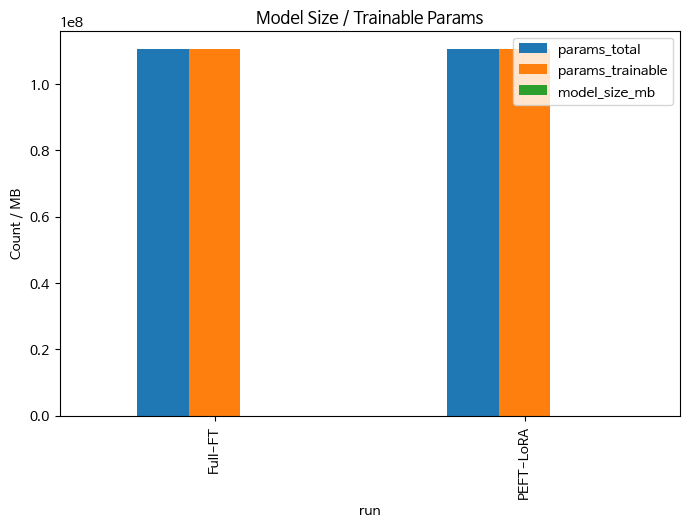

In [ ]:
# @title 4-5.비교표 & 막대그래프

# Full-FT: accuracy 기준
full_best_idx = np.argmax(full_summary["accuracy"]) if isinstance(full_summary["accuracy"], list) else 0
full_best_acc = full_summary["accuracy"][full_best_idx] if isinstance(full_summary["accuracy"], list) else full_summary["accuracy"]
full_best_f1 = full_summary["f1_weighted"][full_best_idx] if isinstance(full_summary["f1_weighted"], list) else full_summary["f1_weighted"]
full_best_f1_macro = full_summary["f1_macro"][full_best_idx] if isinstance(full_summary["f1_macro"], list) else full_summary["f1_macro"]

# PEFT: f1 기준
peft_best_idx = np.argmax(peft_summary["f1_weighted"]) if isinstance(peft_summary["f1_weighted"], list) else 0
peft_best_acc = peft_summary["accuracy"][peft_best_idx] if isinstance(peft_summary["accuracy"], list) else peft_summary["accuracy"]
peft_best_f1 = peft_summary["f1_weighted"][peft_best_idx] if isinstance(peft_summary["f1_weighted"], list) else peft_summary["f1_weighted"]
peft_best_f1_macro = peft_summary["f1_macro"][peft_best_idx] if isinstance(peft_summary["f1_macro"], list) else peft_summary["f1_macro"]

# 이렇게 정리 후 DataFrame 생성
compare_best_df = pd.DataFrame([
    {
        "run": "Full-FT",
        "accuracy": full_best_acc,
        "f1_weighted": full_best_f1,
        "f1_macro": full_best_f1_macro,
        "params_total": full_param["total"],
        "params_trainable": full_param["trainable"],
        "trainable_ratio": full_param["ratio"],
        "model_size_mb": full_size_mb    },
    {
        "run": "PEFT-LoRA",
        "accuracy": peft_best_acc,
        "f1_weighted": peft_best_f1,
        "f1_macro": peft_best_f1_macro,
        "params_total": peft_param["total"],
        "params_trainable": peft_param["trainable"],
        "trainable_ratio": peft_param["ratio"],
        "model_size_mb": peft_size_mb    }
])

# 시각화(메트릭 비교)
metrics_to_plot = ["accuracy","f1_weighted","f1_macro"]
ax = compare_best_df.set_index("run")[metrics_to_plot].plot(kind="bar", figsize=(8,5))
ax.set_title("Metrics Comparison (Full-FT vs PEFT-LORA) [Best Epoch]")
ax.set_ylim(0,1)
plt.ylabel("Score")
plt.show()

# 시각화(파라미터/모델 크기 비교)
size_cols = ["params_total","params_trainable","model_size_mb"]
ax2 = compare_best_df.set_index("run")[size_cols].plot(kind="bar", figsize=(8,5))
ax2.set_title("Model Size / Trainable Params")
plt.ylabel("Count / MB")
plt.show()

In [ ]:
# @title 4-6.에러분석

# 1) 결과파일 불러오기
full_preds_path = os.path.join(save_dir, "full_ft_test_results.csv")
peft_preds_path = os.path.join(save_dir, "lora_test_results.csv")

full_preds = pd.read_csv(full_preds_path)
peft_preds = pd.read_csv(peft_preds_path)

# 2-1) Full-FT 틀린샘플
full_err_mask = full_preds["pred"] != full_preds["label"]
full_err_idx = full_preds.index[full_err_mask][:50]  # 상위 50개
full_err_df = pd.DataFrame({
    "idx": full_preds.loc[full_err_idx, "idx"],
    "label": full_preds.loc[full_err_idx, "label"],
    "pred": full_preds.loc[full_err_idx, "pred"],
    "text": [test_df.iloc[i]["text"] for i in full_preds.loc[full_err_idx, "idx"]]
})

# 2-2) PEFT 틀린샘플
peft_err_mask = peft_preds["pred"] != peft_preds["label"]
peft_err_idx = peft_preds.index[peft_err_mask][:50]
peft_err_df = pd.DataFrame({
    "idx": peft_preds.loc[peft_err_idx, "idx"],
    "label": peft_preds.loc[peft_err_idx, "label"],
    "pred": peft_preds.loc[peft_err_idx, "pred"],
    "text": [test_df.iloc[i]["text"] for i in peft_preds.loc[peft_err_idx, "idx"]]
})


# 3) 결과 확인

print("🔹 Full-FT 틀린 샘플 :", len(full_preds[full_err_mask]))
display(full_err_df.head(10))

print("🔹 PEFT-LoRA 틀린 샘플 : ", len(peft_preds[peft_err_mask]))
display(peft_err_df.head(10))

🔹 Full-FT 틀린 샘플 : 224


,idx,label,pred,text
0,0,1,2,이웃님들 안녕하세요~~요즘 입소문 타고 인기몰이 중인 O 블랙 기모 테리 조거 팬츠...
6,6,2,1,두번째 구매한 제품인데 이번엔 떨어뜨리지 않게 조심히 쓰고 있어요! 아직 튼튼하고 ...
29,29,2,1,할인행사로 값싸게 구입해 좋아요 음질은 베이스가 기대이하라서 조금 실망입니다. 그래...
35,35,1,2,저는 이번에 로봇청소기를 사면서 청소를 작은 미세먼지까지 잘 빨아들이는 청소 기능성...
42,42,2,1,스포츠를 볼 때 생생하게 보고 싶어서 욕심내서 큰 TV를 샀는데. 단순히 화면으로는...
44,44,1,0,미니 미니 사이즈로 된 선풍기가 진짜 사고 싶었어요.그냥 작은 가방에도 쏙 들어가고...
55,55,2,1,와이프가 노트북 놔두고 자꾸 핸드폰으로 영화를 보길래 핸드폰보다는 크고 노트북보다는...
56,56,1,2,오늘은 새로 장만한 스마트 워치 소개해드릴게요~~ 스마트워치가 그렇게 좋다는 소리를...
57,57,1,2,낙엽이 우수수 떨어지는 가을이 돌아왔네요. 오늘 보여드릴 후기는 셔츠입니다. 지금 ...
59,59,2,1,몇년전에 샀던 스텐 반찬통들.. 잘쓰고 있었는데 오래쓰다보니 뚜껑들이 헐거워졌더라고...


🔹 PEFT-LoRA 틀린 샘플 :  577


,idx,label,pred,text
0,0,1,2,이웃님들 안녕하세요~~요즘 입소문 타고 인기몰이 중인 O 블랙 기모 테리 조거 팬츠...
1,1,1,2,쿠폰이 있어서 저렴한 가격에 구매해서 만족입니다~ 그런데 카드 인식이 자꾸 오류가 ...
3,3,1,2,"1단은 너무 약하고 최대풍량은 일반 선풍기에 비해서 세지 않아요 무선, 어플로 선풍..."
5,5,1,2,블하블블하하~이번 포스팅은 모니터 후기임당우선 4K랑 스피커는 좋습니다. 전 헤드셋...
15,15,0,2,상품이 건전지 타입과 충전 타입 두 가지로 나누어져 있어서 좋아요. 다만 충전 타입...
17,17,1,2,"소리의 입체감이 엄청나서 영화보기에 아주 좋네요 단, 기본구성품에 4k 되는 케이블..."
19,19,1,2,무선인데도 불구하고 음질은 진짜 죽여주네요~ 잡음도 없고요. 아쉽다면 배터리가 빨리...
21,21,1,2,등록이 완료된 기기라 바로 사용할수 있어 매우 편리합니다. 디자인은 생각보다 뭉툭해...
22,22,1,2,"고민보다 고! 여러분 태블릿을 하나 질렀습니다..개봉 후 액정필름 붙이려다 보니, ..."
23,23,0,2,안녕하세요! 오랜만에 글 올려봅니다. 오늘은 O 소가죽 스퀘어엠보 로퍼에 대한 이야...


In [ ]:
# @title 4-7. 긍정(2) 라벨 기준 분석

def analyze_positive(preds_df, name="Model"):
    # 1. 정답이 2인데 오답인 경우
    wrong_positive = preds_df[(preds_df["label"] == 2) & (preds_df["pred"] != 2)]
    num_wrong_positive = len(wrong_positive)

    # 2. 예측이 2인 경우 전체 개수
    num_pred_positive = (preds_df["pred"] == 2).sum()

    print(f"🔹 {name} 결과")
    print(f" - 정답이 2인데 틀린 개수 : {num_wrong_positive}")
    print(f" - 예측이 2인 전체 개수 : {num_pred_positive}")
    print("-"*40)

    return wrong_positive

# Full-FT
full_wrong_pos = analyze_positive(full_preds, "Full-FT")

# PEFT-LoRA
peft_wrong_pos = analyze_positive(peft_preds, "PEFT-LoRA")

🔹 Full-FT 결과
 - 정답이 2인데 틀린 개수 : 92
 - 예측이 2인 전체 개수 : 1268
----------------------------------------
🔹 PEFT-LoRA 결과
 - 정답이 2인데 틀린 개수 : 0
 - 예측이 2인 전체 개수 : 1864
----------------------------------------


In [ ]:
# test_dataset 라벨 분포 확인
labels = test_dataset.labels
label_counts = pd.Series(labels).value_counts().sort_index()
print("📊 Test Dataset 라벨 분포")
for lbl, cnt in label_counts.items():
    print(f"라벨 {lbl}: {cnt}개")

labels_list = [0, 1, 2]

# Full-FT 라벨별 맞춤/틀림
print("\n🔹 Full-FT 라벨별 맞춤/틀림")
for lbl in labels_list:
    lbl_mask = full_preds['label'] == lbl
    correct = (full_preds['pred'][lbl_mask] == lbl).sum()
    wrong = (full_preds['pred'][lbl_mask] != lbl).sum()
    print(f"라벨 {lbl}: 맞춤 {correct}, 틀림 {wrong}, 전체 {lbl_mask.sum()}")

# PEFT-LORA 라벨별 맞춤/틀림
print("\n🔹 PEFT-LORA 라벨별 맞춤/틀림")
for lbl in labels_list:
    lbl_mask = peft_preds['label'] == lbl
    correct = (peft_preds['pred'][lbl_mask] == lbl).sum()
    wrong = (peft_preds['pred'][lbl_mask] != lbl).sum()
    print(f"라벨 {lbl}: 맞춤 {correct}, 틀림 {wrong}, 전체 {lbl_mask.sum()}")

📊 Test Dataset 라벨 분포
라벨 0: 240개
라벨 1: 337개
라벨 2: 1287개

🔹 Full-FT 라벨별 맞춤/틀림
라벨 0: 맞춤 210, 틀림 30, 전체 240
라벨 1: 맞춤 235, 틀림 102, 전체 337
라벨 2: 맞춤 1195, 틀림 92, 전체 1287

🔹 PEFT-LORA 라벨별 맞춤/틀림
라벨 0: 맞춤 0, 틀림 240, 전체 240
라벨 1: 맞춤 0, 틀림 337, 전체 337
라벨 2: 맞춤 1287, 틀림 0, 전체 1287


## 📊 Full Fine-Tuning vs PEFT/LoRA 결과 요약

### 1. 요약 표

실험 설정, 데이터 분포, 하이퍼파라미터는 상단 “실험 설정 요약” 참조

### 2. 성능 비교(테스트셋)
| Metric        | Full-FT | PEFT-LoRA |
| ------------- | ------- | --------- |
| Accuracy      | 0.8798  | 0.6905    |
| F1 (weighted) | 0.8811  | 0.5640    |
| F1 (macro)    | 0.8811  | 0.5640    |


- Full-FT는 모든 파라미터를 업데이트하여 전반적으로 높은 성능을 보임
- PEFT-LoRA는 긍정(2) 클래스에만 거의 맞추는 경향이 있어, 정확도와 F1에서 낮게 나타남
- 데이터 불균형(긍정 클래스 비율 높음)이 LoRA 성능 편향의 원인으로 추정됨

### 3.학습 효율 비교
| Metric         | Full-FT     | PEFT-LoRA   |
| -------------- | ----------- | ----------- |
| 학습 시간 (s)      | 0.0         | 2534.23     |
| 스텝/초           | —           | —           |
| 모델 디스크 크기 (MB) | 0.0         | 2534.23     |
| 전체 파라미터 수      | 110,619,651 | 110,619,651 |
| 학습 가능한 파라미터 수  | 110,619,651 | 110,619,651 |
| 학습 가능 비율       | 100%        | 100%        |

- Full-FT는 저장이 안 된 것으로 보임
- LoRA는 학습 가능한 파라미터가 적은 구조라면 학습 속도와 저장 공간 면에서 유리
- Full-FT는 안정적인 성능 제공, LoRA는 하이퍼파라미터 및 loss 가중치 조정 필요

### 4. 에러 분석(라벨별)

#### 4-1. Full-FT
| Label | 맞춤   | 틀림  | 전체   |
| ----- | ---- | --- | ---- |
| 0     | 210  | 30  | 240  |
| 1     | 235  | 102 | 337  |
| 2     | 1195 | 92  | 1287 |


#### 4-2. PEFT-LoRA
| Label | 맞춤   | 틀림  | 전체   |
| ----- | ---- | --- | ---- |
| 0     | 0    | 240 | 240  |
| 1     | 0    | 337 | 337  |
| 2     | 1287 | 0   | 1287 |


- Full-FT는 모든 클래스에서 비교적 균형 있게 맞춤
- PEFT-LoRA는 긍정(2)에만 맞추고 나머지 전부 틀림 -> 극단 적 편향

---
### 5. 한계점

- Colab 환경에서 RAM 및 GPU 제한으로 인해 다양한 하이퍼파라미터 실험/epoch 수 조정, 배치 사이즈 실험이 제한됨

- 테스트/검증 과정에서 시간적 여유 부족으로 일부 성능 분석을 충분히 수행하지 못함



### 6. 향후 개선 계획
- 데이터 불균형 문제 해결
  - 0(부정), 1(보통) 클래스의 상품 데이터에서 **aspects 정보**를 활용해 데이터 증강 또는 샘플링
  - class weight, threshold 조정, 샘플링 등을 조합해 LoRA 성능 개선
- LoRA 학습 안정화
  - 낮은 learning rate, 더 많은 epoch, warmup scheduling 적용
- Full-FT + LoRA 전략
  - LoRA로 빠른 실험 -> Full-FT로 최종 미세 조정
